## EE4140 Digital Communication Systems
### Mini Project

### 1. LMMSE Equalizer 
- 4-QAM / QPSK constellation
- 20 order Wiener Filter
- 6-tap comples FIR Filter

In [283]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz

The `get_r` function convolves the signal with the channel with added gaussian noise.

In [284]:
def get_r(I_k, V_k, channel_f):
    '''
    This function models the transmission of a symbol sequence over an L-tap channel.
    
    I_k : The input symbol sequence.
    V_k : The noise sequence to be added to the transmitted signal.
    channel_f (list): The coefficients of the L-tap channel.

    r_k : The received signal sequence.
    '''
    
    # Determine the number of taps in the channel
    L = len(channel_f)
    
    # Pad the input symbol sequence with zeros at the beginning to account for the delay introduced by the channel
    I_k_padded = np.concatenate((np.zeros(len(channel_f)-1), I_k))
    
    # Convolve the padded input symbol sequence with the channel coefficients
    # The 'same' option is used to return the central part of the convolution that is the same size as I_k
    # The slicing operation selects only those parts of the convolution result that correspond to valid symbol periods
    r_k = np.convolve(I_k_padded, channel_f, 'same')[np.ceil((L-1)/2).astype(int) : -np.floor((L-1)/2).astype(int)]
    
    # Add the noise sequence to the transmitted signal
    r_k += V_k  
    
    return r_k


We define system parameters. 
- symbol energy
- symbol variance (this is a statistical model)
- channel taps
- decoding delay

In [285]:
e_symbol = 1 # average symbol energy
var_I = e_symbol

f_n = [0.9+0.8j, 0.95-0.6j, -0.4+0.5j, 0.15+0.25j, -0.2-0.1j, 0.1-0.05j]
f_n /= np.linalg.norm(f_n) # normalize the channel coefficients
L = len(f_n) # number of taps in the channel

delta = 8 # decoding delay

To obtain $W_{opt}$, the optimal filter coefficients that minimize the mean squared error, we solve the Wiener Hopf equation 
$$R_{YY} \times \ W = R_{IY}$$

In [286]:
def get_wj(SNR, var_I, f_n):
    var_V = 10**(-SNR/10) * var_I # noise variance
    # Generate Ryy, the autocorrelation matrix of the received signal
    # Ryy is a symmetric Toeplitz matrix with the first row and column given by the autocorrelation of the channel
    # 20x20
    f_n_con = np.conj(f_n) # complex conjugate of the channel coefficients
    row = np.array([np.sum(np.abs(f_n)**2)*var_I + var_V,
                    (f_n[1]*f_n_con[0] + f_n[2]*f_n_con[1] + f_n[3]*f_n_con[2]+ f_n[4]*f_n_con[3]+ f_n[5]*f_n_con[4])*var_I,
                    (f_n[2]*f_n_con[0] + f_n[3]*f_n_con[1] + f_n[4]*f_n_con[2]+ f_n[5]*f_n_con[3])*var_I,
                    (f_n[3]*f_n_con[0] + f_n[4]*f_n_con[1] + f_n[5]*f_n_con[2])*var_I,
                    (f_n[4]*f_n_con[0] + f_n[5]*f_n_con[1])*var_I,
                    (f_n[5]*f_n_con[0])*var_I,
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0
                    ])

    # R_YY = toeplitz(r=row, c=row)
    R_YY = toeplitz(row).T

    # Generate R_IY, the cross-correlation matrix between the input and the received signal
    # 20x1
    R_IY = np.array([0, 0, 0, f_n[5], f_n[4], f_n[3], f_n[2], f_n[1], f_n[0], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]).reshape(20,1)*var_I
    W_opt = np.matmul(np.linalg.inv(R_YY), R_IY) # optimal MMSE filter
    
    # J_min = var_I - 2*np.matmul(W_opt.T, R_IY).real + np.matmul(np.matmul(W_opt.T, R_YY), np.conj(W_opt))# minimum mean square error 
    # J_min[idx] = np.abs((sigma_i_2 - np.dot(np.transpose(np.conj(p_delta)),W_opt)))*(1.00)

    J_min = var_I - np.dot(np.conj(R_IY).T, W_opt)
    
    return W_opt.flatten(), J_min.flatten()

Once, the Wiener filter is ready, we calculate SER for different SNR values.

In [287]:
def get_I_hat_SER(I_k, w_k, f_n, delta, var_v):
    '''
    Here we convolve the received sequence with the equalizer 

    return: I_hat_k(k-delta)

    - last delta symbols are not decoded
    '''

    N_w = len(w_k)
    N_samp = len(I_k)
    L = len(f_n)


    r_k = np.convolve(I_k, np.conj(f_n))[L-1:N_samp] # done

    y_k = np.convolve(r_k, w_k)[N_w-1: N_samp-L+1] # done

    noise = np.random.normal(0, np.sqrt(var_v), N_samp-L+1) + 1j*np.random.normal(0, np.sqrt(var_v), N_samp-L+1)
    filter_noise = np.convolve(noise, w_k)[N_w-1: N_samp-L+1]

    y_k += filter_noise

    dmin = 1/np.sqrt(2)

    I_hat_k = np.zeros(len(y_k))*(1+1j)
    I_hat_k[y_k.real < 0] = -dmin
    I_hat_k[y_k.real > 0] = dmin
    I_hat_k[y_k.imag < 0] += -1j*dmin
    I_hat_k[y_k.imag > 0] += 1j*dmin

    # now calculate SER
    SER = 0

    for i in range(N_w+L-delta-2, N_samp-delta):
        if abs(I_hat_k[i-(N_w+L-delta-2)] - I_k[i]) > 1e-3:
            SER += 1/N_samp

    return SER


SNR:  8
J_min:  [0.26302691-1.11022302e-16j]
SER:  0.18321602815320215


SNR:  10
J_min:  [0.20997223+2.77555756e-17j]
SER:  0.1256398464368783


SNR:  12
J_min:  [0.16624373-5.55111512e-17j]
SER:  0.07629168999441194


SNR:  14
J_min:  [0.13056582+1.11022302e-16j]
SER:  0.04305966568023828


SNR:  16
J_min:  [0.10205512-5.55111512e-17j]
SER:  0.01901543629528836


SNR:  18
J_min:  [0.08002884+5.27355937e-16j]
SER:  0.006478445173158489


SNR:  20
J_min:  [0.06369866-2.49800181e-16j]
SER:  0.00152963288810685


SNR:  22
J_min:  [0.05207503+8.32667268e-17j]
SER:  0.0002399424138206829


SNR:  24
J_min:  [0.04408535-5.55111512e-17j]
SER:  9.997600575861792e-06




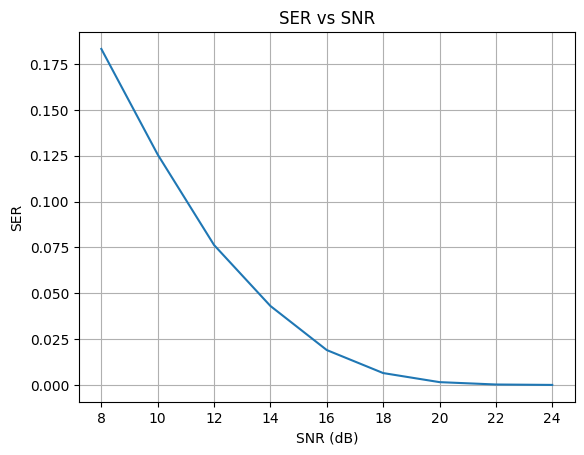

In [289]:
# Now we calculate SER
# Generate the input symbol sequence
N_wiener = 20
N_samp = 100000 + N_wiener + len(f_n) - 2 # number of symbols
dmin = 1/np.sqrt(2) # unit energy

SNR = np.arange(8, 26, 2) # signal-to-noise ratio in dB
I_k = np.random.choice([-dmin, dmin], N_samp) + 1j*np.random.choice([-dmin, dmin], N_samp) # input symbol sequence
SER = []
for snr in SNR:
    W_opt, J_min = get_wj(snr, var_I, f_n)
    print("SNR: ", snr)
    print("J_min: ", J_min)
    var_V = 10**(-snr/10) * var_I # noise variance

    ser = get_I_hat_SER(I_k, W_opt, f_n, delta, var_V)
    SER.append(ser)
    print("SER: ", ser)
    print("\n")

plt.plot(SNR, SER)
plt.xlabel("SNR (dB)")
plt.ylabel("SER")
plt.title("SER vs SNR")
plt.grid()
plt.show()

### 2. B&G Blind Adaptive Algorithm
- Now, we implement the Benvenisti and Goursat (B&G) blind adaptive algorithm.
- We aim to compare the performance of the B&G algorithm with the LMMSE equalizer.

NOTE: Nomenclature used is from the article "Blind Equalizers" by Albert Benvenisti and Maurice Goursat.

We begin by generating a QPSK sequence `a_t` of 10,000 symbols. We then pass it through a channel with 6-tap FIR filter and add gaussian noise. We obtain the received signal `x_t`.

In [277]:
N_samp = 30000 
dmin = 1/np.sqrt(2) # unit energy

a_t = np.random.choice([-dmin, dmin], N_samp) + 1j*np.random.choice([-dmin, dmin], N_samp) # input symbol sequence

# add noise
var_v = 10**(-SNR[1]/10) * var_I # noise variance
noise = np.random.normal(0, np.sqrt(var_v), N_samp) + 1j*np.random.normal(0, np.sqrt(var_v), N_samp)
x_t = get_r(a_t, noise, f_n)


The Blind Equalizer will receive these `x_t` samples one by one. It starts with a random parameter vector and updates it. 

In [278]:
N_eq = 21
N_half = int((N_eq-1)/2)

def sato_function(x, alpha):
    return (x**2)/2 - alpha*np.abs(x)

def blind_deconvolution(x_t, d):
    ''' 
    We will use a 21 point vector in the equalizer.
    '''
    # hyperparameters
    k1 = 3 # customary error weight
    k2 = 1 # Sato error weight
    gamma = 1e-3
    mu = 1e-3

    # initialize equalizer
    theta_t = np.ones(N_eq) * (0+0j)
    # theta_t[np.random.randint(0, N_eq)] = 1
    theta_t[N_half] = 1
    phi_t = np.random.uniform(0, 2*np.pi) # phase

    # symbols = [(dmin+dmin*1j), (dmin-dmin*1j), (-dmin+dmin*1j), (-dmin-dmin*1j)]
    alpha = d

    a_hat_t = np.zeros(N_samp)*(0+0j)
    sato_cost_hist = []
    pseudo_error_hist = []
    error_rate = []
    c_t_hist = np.zeros(N_samp)*(0+0j)

    for t in range(0, N_samp-N_half):
        # get sample vector X_t
        if t < N_half:
            # blind startup period
            X_t = np.concatenate((np.zeros(N_half-t), x_t[:t+N_half+1]))
        else:
            # normal receiving period
            X_t = x_t[t-N_half:t+N_half+1]
            
        X_t = np.flip(X_t)

        # deconvolved c_t
        c_t = np.dot(theta_t, X_t) * np.exp(-1j*phi_t)
        c_t_hist[t] = c_t

        # decision circuit
        # if c_t.real < 0:
        #     a_hat_t[t] = -dmin
        # else:
        #     a_hat_t[t] = dmin

        # if c_t.imag < 0:
        #     a_hat_t[t] += -1j*dmin
        # else:
        #     a_hat_t[t] += 1j*dmin
        a_hat_t[t] = alpha * (np.sign(c_t.real) + 1j*np.sign(c_t.imag))


        # calculate pseudo error signal
        # 1. customary error signal
        e_t = a_hat_t[t] - c_t

        # 2. pseudo error signal (Sato based)
        c_hat_t = alpha * (np.sign(c_t.real) + 1j*np.sign(c_t.imag))
        e_s_t = c_hat_t - c_t

        # G-pseudo error signal (G-Sato based)
        e_g_t = k1 * e_t + k2 * np.abs(e_t) * e_s_t

        # update parameters
        theta_t += gamma * np.conj(X_t) * np.exp(1j*phi_t) * e_g_t
        # theta_t /= np.linalg.norm(theta_t)
        phi_t += mu * (c_t * np.conj(e_g_t)).imag 
        phi_t %= 2*np.pi
        

        # sato_cost evolution
        # calculate the mean of sato(real(ct)) + sato(imag(ct))
        sato_cost_hist.append(
                np.mean(sato_function(c_t_hist[:t+1].real, alpha)) + 
                np.mean(sato_function(c_t_hist[:t+1].imag, alpha))
                )
        

        # Calculate Error Rate on the last 10 samples
        if t > 10:
            error_rate.append(np.mean(np.abs(a_t[t-10:t+1] - a_hat_t[t-10:t+1]) > 1e-2) * 100)

        # Print sato_cost at t
        if t % 1000 == 0:
            print(f"Sato Cost at t = {t}: ", sato_cost_hist[-1])
            # pseudo_error_hist.append(np.abs(np.conj(X_t) * np.exp(1j*phi_t) * e_g_t))

    return a_hat_t, sato_cost_hist, pseudo_error_hist, error_rate


In [279]:
a_hat_t, sato_cost_hist, egt, error_rate = blind_deconvolution(x_t, dmin)

Sato Cost at t = 0:  -0.42430802521484756


Sato Cost at t = 1000:  -0.3286379604253904
Sato Cost at t = 2000:  -0.33787528093612706
Sato Cost at t = 3000:  -0.3498281799103143
Sato Cost at t = 4000:  -0.3645291485349538
Sato Cost at t = 5000:  -0.37915288153376026
Sato Cost at t = 6000:  -0.3882254619353869
Sato Cost at t = 7000:  -0.3969805964802726
Sato Cost at t = 8000:  -0.40344167554365357
Sato Cost at t = 9000:  -0.40893229827973454
Sato Cost at t = 10000:  -0.4130324917045022
Sato Cost at t = 11000:  -0.4167695247147038
Sato Cost at t = 12000:  -0.4197565100678792
Sato Cost at t = 13000:  -0.4228200326959182
Sato Cost at t = 14000:  -0.42491892273050214
Sato Cost at t = 15000:  -0.42683019396215505
Sato Cost at t = 16000:  -0.4285305523144566
Sato Cost at t = 17000:  -0.4299984981116154
Sato Cost at t = 18000:  -0.4313351431703062
Sato Cost at t = 19000:  -0.4325888015234152
Sato Cost at t = 20000:  -0.433807967410642
Sato Cost at t = 21000:  -0.43459926971119456
Sato Cost at t = 22000:  -0.4355495015868213
Sato Cost at 

Plot MSE history and Error Rate evolution.

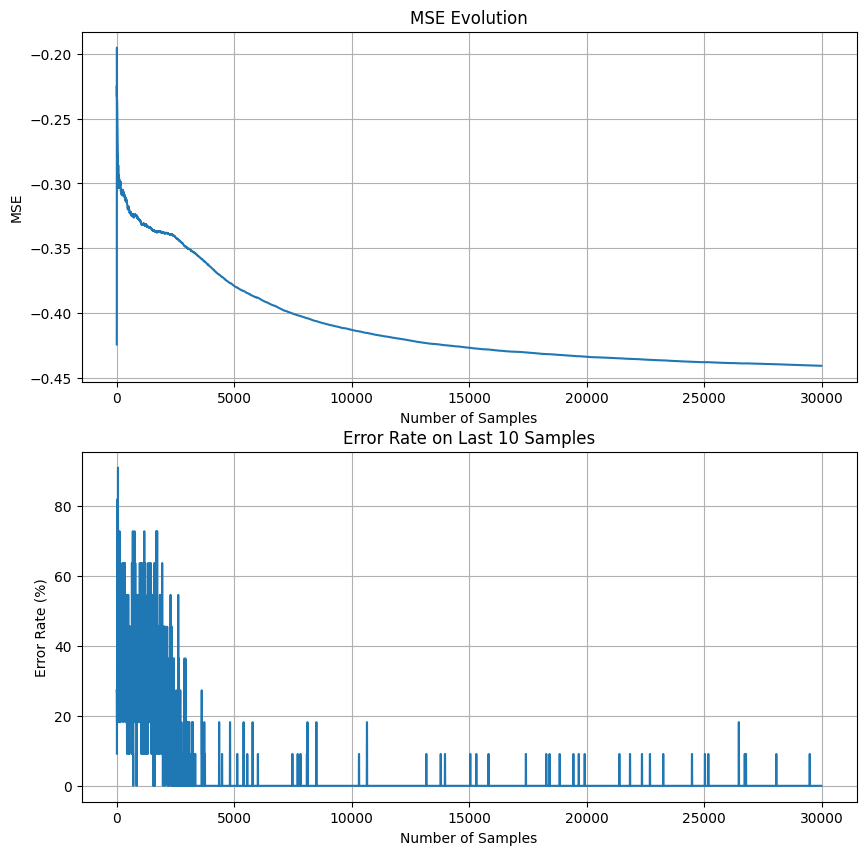

In [280]:
# Plot MSE History anf Error Rate Evolution in subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(sato_cost_hist)
ax[0].grid()
ax[0].set_xlabel("Number of Samples")
ax[0].set_ylabel("MSE")
ax[0].set_title("MSE Evolution")
ax[1].plot(error_rate)
ax[1].grid()
ax[1].set_xlabel("Number of Samples")
ax[1].set_ylabel("Error Rate (%)")
ax[1].set_title("Error Rate on Last 10 Samples")
plt.savefig("mse_error_rate.png")
plt.show()

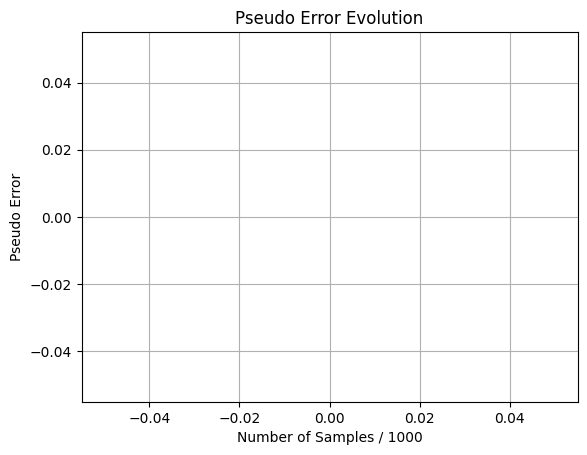

In [281]:
# plot egt
plt.plot(egt)
plt.grid()
plt.xlabel("Number of Samples / 1000")
plt.ylabel("Pseudo Error")
plt.title("Pseudo Error Evolution")
# plt.savefig("pseudo_error.png")
plt.show()

Now, we need to calculate SER. We do this by comparing the estimated symbols with the original symbols.


In [282]:
def get_SER(a_t, a_hat_t):
    SER = 0
    for i in range(N_half-1, N_samp-N_half-1):
        if abs(a_t[i] - a_hat_t[i]) > 1e-3:
            SER += 1/len(a_t)
    SER *= 100
    return SER

SER = get_SER(a_t, a_hat_t)
print("SER (%): ", SER)

SER (%):  3.1099999999999826
